In [1]:
import numpy as np
import time

from multi_analysis_dfc import (
    MultiAnalysis, 
    data_loader,
)
from multi_analysis_dfc.dfc_utils import TR_intersection
from multi_analysis_dfc.comparison import SimilarityAssessment


### Parameters 

    1. Set paths to the data folders, select data type, and the sessions of the data and networks that you want to include

In [2]:
params_data_load = { 
    # data root
    'data_root': './sampleDATA/',
    # file name
    'file_name': 'ROI_data_Gordon_333_surf.mat',
    # SESSION
    'SESSIONs': ['Rest1_LR'], 
    # networks to include in analysis
    'networks2include':['Auditory', 'CinguloOperc', 'Default', 'DorsalAttn', 'FrontoParietal',
        'MedialParietal', 'ParietoOccip', 'SMhand', 'SMmouth',
        'Salience', 'VentralAttn', 'Visual'], 
    # locs
    'roi_locs_file': 'center_locs.npy',
    # labels
    'roi_labels_file': 'region_labels.npy',
    # sampling frequency
    'Fs': 1/0.72,
}

    2. Set the default parameter values for dFC assessment

In [3]:
params_methods = { \
    # Sliding Parameters
    # W is in sec
    'W': 44, 'n_overlap': 0.5, 'sw_method':'pear_corr', 'tapered_window':True, \
    # TIME_FREQ
    'TF_method':'WTC', \
    # CLUSTERING AND DHMM
    'clstr_base_measure':'SlidingWindow', \
    # HMM
    'hmm_iter': 50, 'n_hid_states': 24, \
    # State Parameters
    'n_states': 12, 'n_subj_clstrs': 20, \
    # Parallelization Parameters
    'n_jobs': 2, 'verbose': 0, 'backend': 'loky', \
    # SESSION
    'session': 'Rest1_LR', \
    # Hyper Parameters
    'normalization': True, \
    'num_subj': 2, \
    'num_select_nodes': 96, \
    'num_time_point': 1200, \
    'Fs_ratio': 1.00, \
    'noise_ratio': 0.00, \
    'num_realization': 1 \
}

    3. Specify the list of methods you want to include:

In [4]:
MEASURES_name_lst = [ 
                'SlidingWindow', 
                # 'Time-Freq', 
                # 'CAP', 
                # 'ContinuousHMM', 
                'Windowless', 
                # 'Clustering', 
                # 'DiscreteHMM' 
]

    4. You may set a list of alternative values for each parameter

Here for example, we want to run the analysis also with 6 number of states:

In [5]:
alter_hparams = { 
            'n_states': [6], 
}

    5. Set parameter values for dFC Analyzer

In [6]:
params_dFC_analyzer = { \
    # Parallelization Parameters
    'n_jobs': None, 'verbose': 0, 'backend': 'loky' 
}

### LOAD DATA

Creating Data Loader object and loading the data as a Time Series object

In [7]:
BOLD = data_loader.load_from_array(**params_data_load)
SUBJECTS_list = data_loader.find_subj_list(params_data_load['data_root'])

2 subjects were found. 
*** Session Rest1_LR: 
number of regions= 286, number of TRs= 1200
2 subjects were found. 


How the info dictionary of the loaded Time Series look like:

In [ ]:
BOLD['Rest1_LR'].info

This is what the BOLD signals look like:

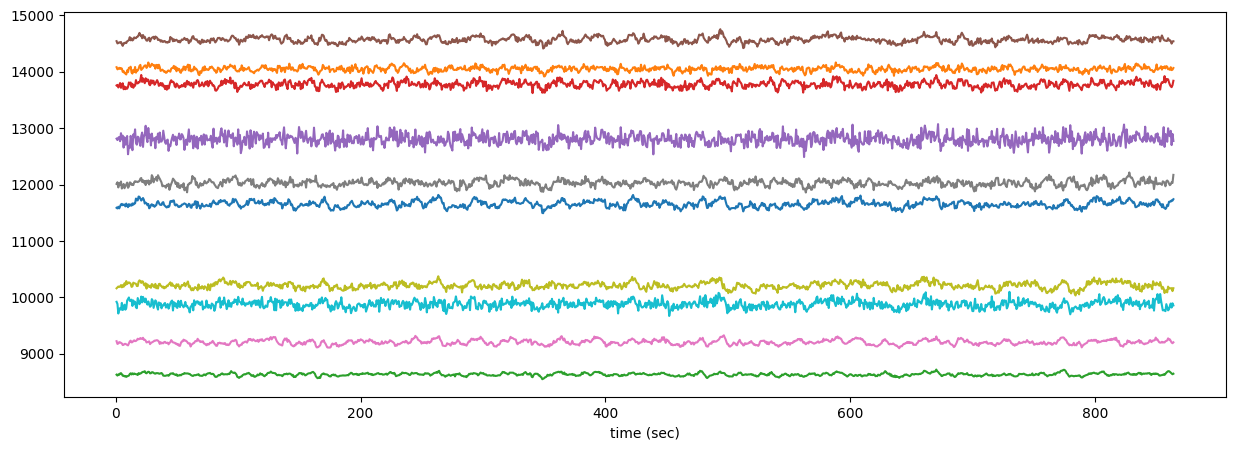

In [9]:
BOLD['Rest1_LR'].visualize(
    start_time=0, end_time=1000, 
    nodes_lst=range(10), 
)

### Measures of dFC 

    1. Create dFC Multi-Analysis object:

In [10]:
dFC_analyzer = MultiAnalysis( 
    analysis_name='reproducibility assessment', 
    **params_dFC_analyzer 
)

    2. Initialize the list of measures with the given hyperparameters

In [11]:
MEASURES_lst = dFC_analyzer.measures_initializer( 
    MEASURES_name_lst, 
    params_methods, 
    alter_hparams 
)

There are one instance of SlidingWindow, and two instances of Window-less, one with 12 states and the other one with 6 states.

In [12]:
print(MEASURES_lst)

[<multi_analysis_dfc.dfc_methods.sliding_window.SLIDING_WINDOW object at 0x7fc106ec1a00>, <multi_analysis_dfc.dfc_methods.windowless.WINDOWLESS object at 0x7fc106ec1d00>, <multi_analysis_dfc.dfc_methods.windowless.WINDOWLESS object at 0x7fc106ec1940>]


### estimate FC states

Run FCS estimation for state-based methods only and collect them in MEASURES_fit_lst

In [13]:
tic = time.time()
print('Measurement Started ...')

MEASURES_fit_lst = list()
for measure in MEASURES_lst:

    time_series = BOLD[measure.params['session']]
    if measure.is_state_based:
        measure.estimate_FCS(time_series=time_series)
    MEASURES_fit_lst.append(measure)
            
print('Measurement required %0.3f seconds.' % (time.time() - tic, ))

dFC_analyzer.set_MEASURES_fit_lst(MEASURES_fit_lst)

Measurement Started ...


Measurement required 2.535 seconds.


How info dictionary of a measure looks like (e.g. for the SlidingWindow object):

In [14]:
MEASURES_fit_lst[0].info

{'sw_method': 'pear_corr',
 'tapered_window': True,
 'W': 44,
 'n_overlap': 0.5,
 'normalization': True,
 'num_select_nodes': 96,
 'num_time_point': 1200,
 'Fs_ratio': 1.0,
 'noise_ratio': 0.0,
 'num_realization': 1,
 'session': 'Rest1_LR',
 'measure_name': 'SlidingWindow',
 'is_state_based': False}

### dFC assessment

Assess each subject's dFC using the fitted measure objects:

In [15]:
tic = time.time()
print('Measurement Started ...')

print("dFC estimation started...")

SUBJ_dFC_dict = {}
for subj in SUBJECTS_list:
    BOLD = data_loader.load_from_array(subj_id2load=subj, **params_data_load)
    dFC_dict = dFC_analyzer.subj_lvl_dFC_assess(time_series_dict=BOLD)
    SUBJ_dFC_dict[subj] = dFC_dict

print("dFC estimation done.")

print('Measurement required %0.3f seconds.' % (time.time() - tic, ))

Measurement Started ...
dFC estimation started...


*** Session Rest1_LR: 
number of regions= 286, number of TRs= 1200
*** Session Rest1_LR: 
number of regions= 286, number of TRs= 1200
dFC estimation done.
Measurement required 65.807 seconds.


    VISUALIZE dFC

You may filter the dFCMs you want to visualize by specifying values of parameters in param_dict:

In [17]:
dFC_lst = SUBJ_dFC_dict[subj]['dFC_lst']

Visualize a sample interval of assessed dFC using different measures:

SlidingWindow
Windowless
Windowless


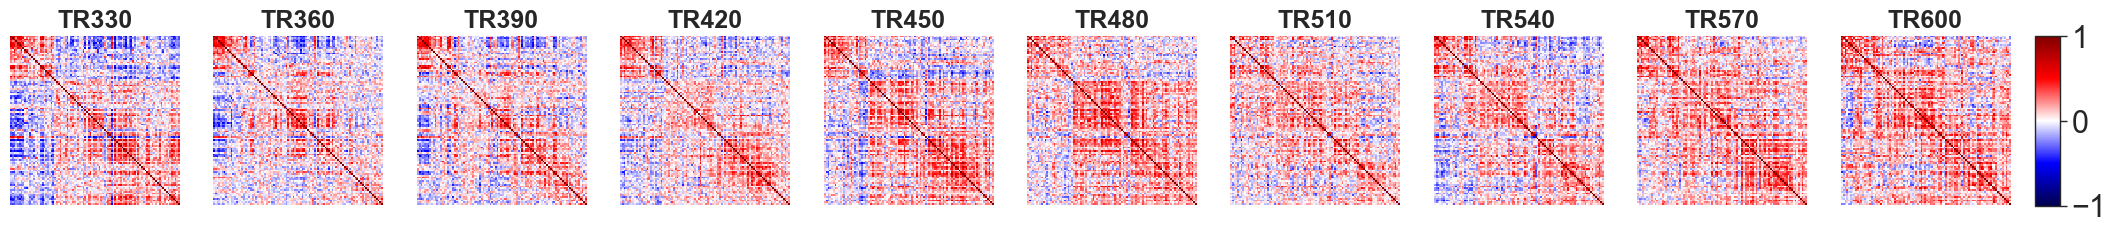

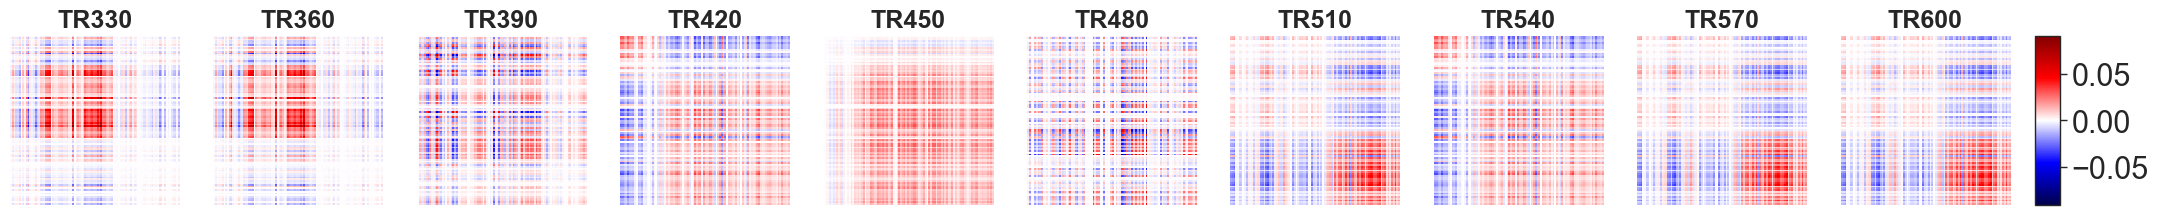

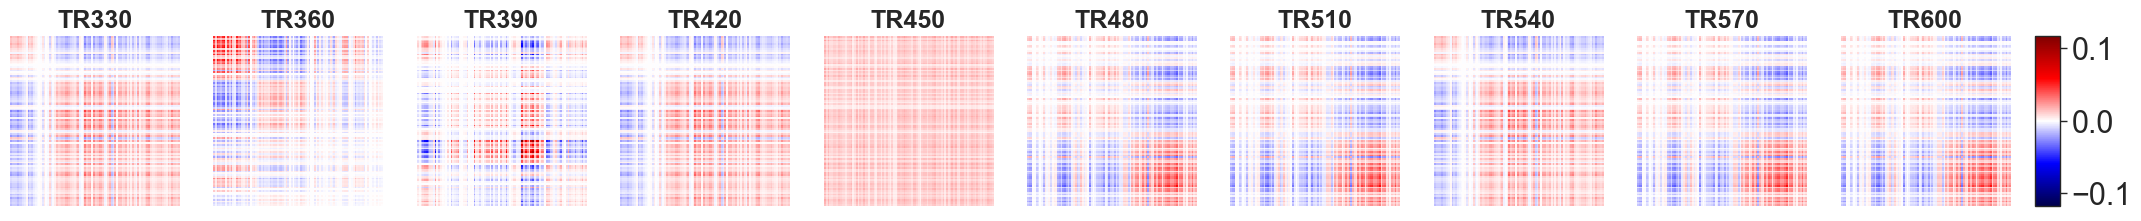

In [18]:
TRs = TR_intersection(dFC_lst)
chosen_TRs = TRs[10:20]

for dFC in dFC_lst:
    print(dFC.measure.measure_name)
    dFC.visualize_dFC(TRs=chosen_TRs, normalize=False, fix_lim=False)

### Similarity assessment

In [19]:
similarity_assessment = SimilarityAssessment(dFC_lst=dFC_lst)

tic = time.time()
print('Measurement Started ...')

print("Similarity measurement started...")
SUBJ_output = similarity_assessment.run(FILTERS=dFC_analyzer.hyper_param_info, downsampling_method='default')
print("Similarity measurement done.")

print('Measurement required %0.3f seconds.' % (time.time() - tic, ))

Measurement Started ...
Similarity measurement started...


Similarity measurement done.
Measurement required 73.536 seconds.


This is what similarity results of each subject contain:

In [20]:
print(SUBJ_output.keys())
print(SUBJ_output['default_values'].keys())

dict_keys(['default_values', 'n_states_6'])
dict_keys(['measure_lst', 'TS_info_lst', 'common_TRs', 'dFC_samples', 'time_record_dict', 'all', 'feature_based', 'graph_based', 'dFC_avg', 'dFC_var', 'FO', 'transition_stats'])


### Post Analysis

    1. Create a dictionary containing RESULTS to be visualized

In [21]:
metric = 'spearman'
filter = 'default_values'

similarity_mat = np.squeeze(SUBJ_output[filter]['all'][metric])
methods_names = [measure.measure_name for measure in SUBJ_output[filter]['measure_lst']]
RESULTS = {'session1_LR':{
                        'similarity_mat':similarity_mat,
                        'methods_names':methods_names
            }
}

    2. VISUALIZE Similarity results

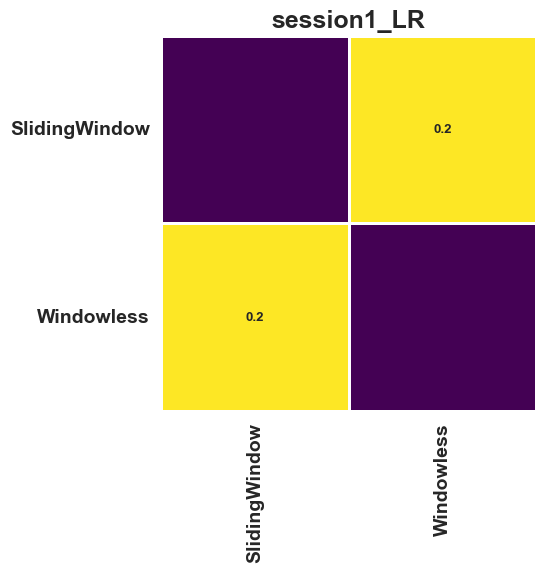

In [22]:
from multi_analysis_dfc.comparison.plotting import visualize_sim_mat

visualize_sim_mat(RESULTS, 
                    mat_key='similarity_mat', 
                    name_lst_key='methods_names', 
                    cmap='viridis',
)